In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

To start off with, we can look at the Strava data provided by Nick and see whether it is usable.

In [12]:
nick_data = pd.read_csv('/Users/aayush/Documents/Run4It/Run4It/Model/Data/activities.csv')
nick_data['Activity Date'] = pd.to_datetime(nick_data['Activity Date'], format='%d %b %Y, %H:%M:%S')
nick_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 78 columns):
 #   Column                                                                                          Non-Null Count  Dtype         
---  ------                                                                                          --------------  -----         
 0   Activity ID                                                                                     225 non-null    int64         
 1   Activity Date                                                                                   225 non-null    datetime64[ns]
 2   Activity Name                                                                                   225 non-null    object        
 3   Activity Type                                                                                   225 non-null    object        
 4   Activity Description                                                                            10

(25, 72)


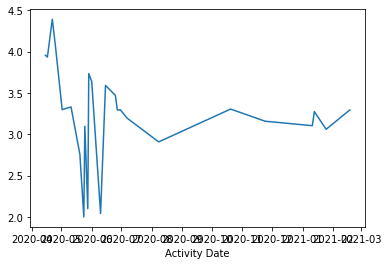

In [45]:
# Grouping by day and only looking at bike rides 
run = nick_data[nick_data['Activity Type']=='Run'].groupby(nick_data['Activity Date'].dt.date).mean()
run['Average Speed'].plot()
print(run.shape)

Strava data from Nick: Limited for ML purposes due to the low volume of data. Not enough to accurately make predictions. Potentially can synthesise results using this and use that data for POC. Easier way to synthesise nutrition data as well, because we know roughly what Nick eats on a regular basis. Also have Gousto information available.

In [46]:
run.to_csv('nick_running.csv', index=False)